In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout 
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

plt.style.use('ggplot')


In [2]:
test_df = pd.read_csv('../data/Data_B_nolabels.csv', header=None)

columns=['ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

test_df.columns = columns

df = pd.read_csv('../data/Data_A.csv', header=None)

columns=['midprice_up','ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

df.columns = columns

price_cols = ['ss_lob_1_p','bs_lob_1_p','ss_lob_2_p','bs_lob_2_p','ss_lob_3_p','bs_lob_3_p','ss_lob_4_p','bs_lob_4_p']
vol_cols = ['ss_lob_1_v','bs_lob_1_v','ss_lob_2_v','bs_lob_2_v','ss_lob_3_v','bs_lob_3_v','ss_lob_4_v','bs_lob_4_v']
prev_mid_m_cols = ['c1', 'c2', 'c3', 'c4', 'c5']


In [15]:
df.isna().any(axis=0).any()
# no nulls

False

In [3]:
df['midprice_up'].value_counts()

1    50267
0    49733
Name: midprice_up, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


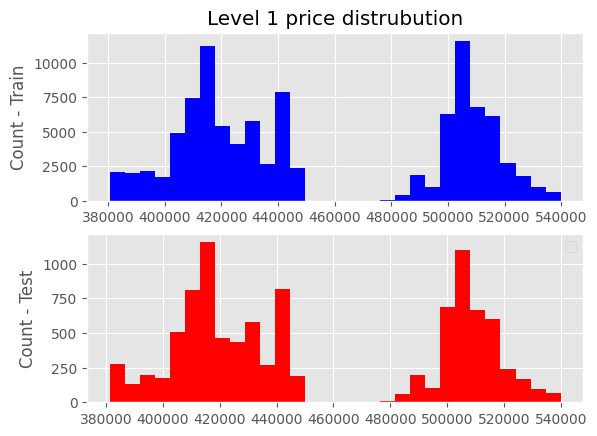

In [4]:
fig, axs = plt.subplots(2, 1)

df['bs_lob_1_p'].hist(bins=30, ax=axs[0], color='b'); 
axs[0].set_ylabel('Count - Train')

test_df['bs_lob_1_p'].hist(bins=30, ax=axs[1], color='r')
axs[1].set_ylabel('Count - Test')

axs[0].set_title("Level 1 price distrubution")
plt.legend()
plt.show()

# we seem two have two underlying distrubutins for both the test and training dataset.
# distrubutions are ~1.2x different

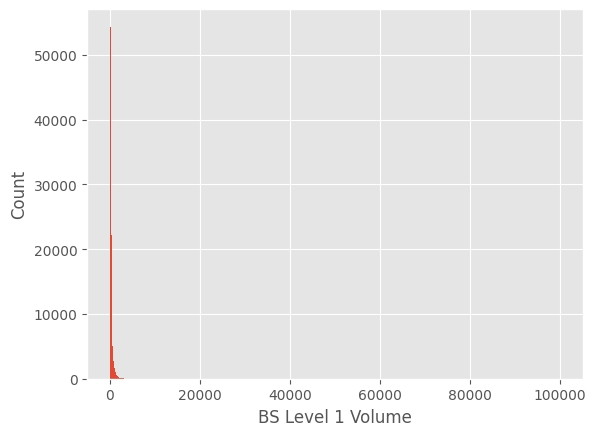

In [21]:
ax = df['bs_lob_1_v'].hist(bins=500)
ax.set_xlabel('BS Level 1 Volume')
ax.set_ylabel('Count')
plt.show()
# some very large volume outliers

In [5]:
# engineer features

# cumulative l1+l2 volume
df['ss_lob_12_v'] = df['ss_lob_1_v']+df['ss_lob_2_v']
df['bs_lob_12_v'] = df['bs_lob_1_v']+df['bs_lob_2_v']

# difference of order book volume (L1)
df['l1_diff']= df['ss_lob_1_v']-df['bs_lob_1_v']
df['l12_diff']= df['ss_lob_12_v']-df['bs_lob_12_v']

df['midprice'] = (df['bs_lob_1_p']+df['ss_lob_1_p'])/2

# L1 VWAP
df['vwap'] = (df['bs_lob_1_p']*df['bs_lob_1_v'] + df['ss_lob_1_p']*df['ss_lob_1_v'])/(df['ss_lob_1_v']+df['bs_lob_1_v'])
df['vwap_gt_mid'] = (df['vwap'] > df['midprice']).astype(float)

# Indicator if there is more L1 buyside pressure
df['bs_pressure1'] = (df['bs_lob_1_v']>df['ss_lob_1_v']).astype(int)

# Average of last 5 moves
df['avg_5'] = df[prev_mid_m_cols].mean(axis=1)

# Momentum indicator
df['momentum_up'] = (df['avg_5']>0.5).astype(int)



In [6]:
df['avg_5'] = df[['c1','c2','c3','c4','c5']].mean(axis=1)
df[df['midprice_up']==1]['avg_5'].mean()

0.48705910438259703

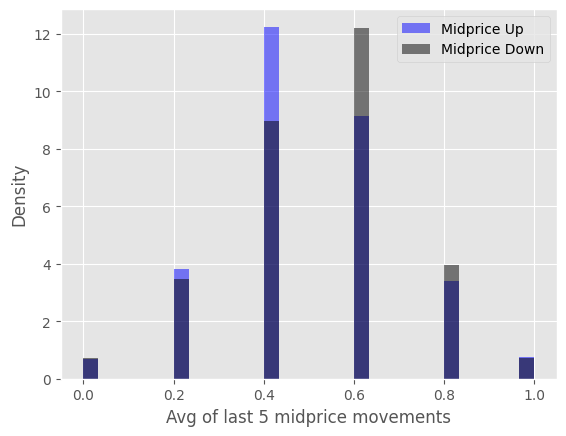

In [7]:
fig, ax = plt.subplots()
ax.hist(df[df['midprice_up']==1]['avg_5'], label='Midprice Up', color='b', alpha=0.5, density=True, bins=30)
ax.hist(df[df['midprice_up']==0]['avg_5'], label='Midprice Down', color='k', alpha=0.5, density=True, bins=30)
ax.set_xlabel('Avg of last 5 midprice movements')
ax.set_ylabel('Density')

ax.legend()
plt.show()

##  midprice more likely to go up (resp. down) if recent moves were down (resp. up)

#### Fit a random forest

In [8]:
X = df.drop(columns=['midprice_up'])

Y = df['midprice_up']
X_train, X_test, y_train, y_test = train_test_split(X, Y)

rf = RandomForestClassifier(n_estimators = 100, max_depth=9)

fit = rf.fit(X_train,y_train.to_numpy())


#### Use RF to find important features

In [24]:

Y = df[['midprice_up']]
X = df.drop(columns=['midprice_up'])

rf = RandomForestClassifier(n_estimators = 100, max_depth=7, max_features=5)

sel = SelectFromModel(rf)
sel.fit(X, Y)

y_pred = fit.predict(X_test)

fit = rf.fit(X_train,y_train.to_numpy())

print(f"Train accuracy {accuracy_score(y_train, fit.predict(X_train)):.3f}")
print(f'Test accuracy : {accuracy_score(y_test, y_pred):.3f}')


selected_feat= X.columns[(sel.get_support())]
s = pd.Series(index=sel.estimator_.feature_names_in_, data=sel.estimator_.feature_importances_)


c:\Users\George\projects\masters\dl_cw\venv\lib\site-packages\sklearn\feature_selection\_from_model.py:355: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Train accuracy 0.771
Test accuracy : 0.766


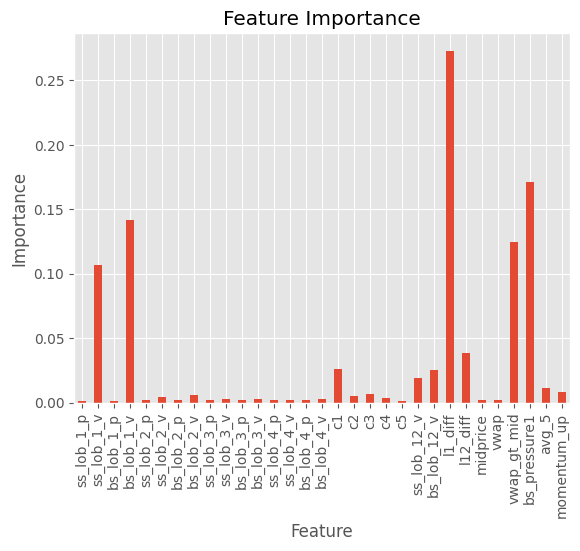

In [25]:
s.plot.bar()
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.savefig('./plots/feature_importance.png', bbox_inches='tight')